## ================================================================
## Action Potential Alignment and Error Quantification
## ================================================================
Load simulated voltage traces generated with different integration
time steps (dt). Align them by their peak times and compute the 
root mean square error (RMSE) relative to the reference trace 
(highest temporal resolution). This analysis quantifies the 
numerical deviation introduced by coarser integration steps.
The traces are used to generate Supplementary Figure S1.

10.0 µs vs 1 µs: RMSE = 4.5712 mV
100.0 µs vs 1 µs: RMSE = 4.7746 mV
500.0 µs vs 1 µs: RMSE = 24.1224 mV


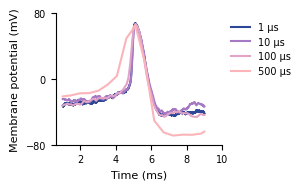

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

num_samples = []
traces = []
filenames = []


# ------------------------------------------------
# Load all .npy traces and extract their lengths
# ------------------------------------------------
for file in os.listdir():
    if file.endswith(".npy"):
        trace = np.load(file)
        traces.append(trace)
        num_samples.append(trace.shape[0])
        filenames.append(file)

# ------------------------------------------------
# Sort traces by decreasing number of samples (i.e., increasing precision)
# ------------------------------------------------
sorted_indices = np.argsort(num_samples)[::-1]
traces_sorted = [traces[i] for i in sorted_indices]
num_samples_sorted = [num_samples[i] for i in sorted_indices]

# ------------------------------------------------
# Reference trace (highest resolution)
# ----------------------------------------------
ref_trace = traces_sorted[0]
ref_samples = num_samples_sorted[0]
t_ref = np.linspace(0, 10, ref_samples)
ref_peak_idx = np.argmax(ref_trace)
t_ref_peak = t_ref[ref_peak_idx]

# Select a time window around the main action potential
mask = (t_ref >= 1) & (t_ref <= 9)
t_window = t_ref[mask]
ref_window = ref_trace[mask]

# ------------------------------------------------
# Plot overlay and compute RMSEs
# ------------------------------------------------
colors = ['#fbb4b9',
          '#e1a3c6',
          '#a579c4',
          '#2d4896'][::-1]

fig, ax = plt.subplots(figsize=(8/2.54, 5.1/2.54))
ax.plot(t_window, ref_window, colors[0], label=f'{int(1e4 / ref_samples)} µs')

errors = []

for i, (trace, color) in enumerate(zip(traces_sorted[1:], colors[1:]), start=1):
    N = trace.shape[0]
    t = np.linspace(0, 10, N)

    peak_idx = np.argmax(trace)
    t_peak = t[peak_idx]

    delta_t = t_peak - t_ref_peak
    t_shifted = t - delta_t

    aligned_trace = np.interp(t_ref, t_shifted, trace, left=0, right=0)

    aligned_window = aligned_trace[mask]
    rmse = np.sqrt(np.mean((aligned_window - ref_window) ** 2))
    errors.append(rmse)
    dt_us = 1e4 / N
    print(f'{dt_us:.1f} µs vs 1 µs: RMSE = {rmse:.4f} mV')

    ax.plot(t_window, aligned_window, color=color, label=f'{int(dt_us)} µs')

ax.set_xlabel('Time (ms)', fontsize=8)
ax.set_ylabel('Membrane potential (mV)', fontsize=8)
ax.legend(frameon=False, fontsize=7, loc='upper left', bbox_to_anchor=(1, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=7)

ax.set_yticks([-80, 0, 80])
ax.set_xticks([2, 4, 6, 8, 10])

plt.tight_layout()
fig.savefig("AP_overlap.tif", dpi=300, bbox_inches="tight")